In [84]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime as dt

from datetime import timedelta

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance

In [237]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, fcluster

### Useful functions

In [4]:
def get_stats(db,col_list):
    
    """
    Calculate basic stats for column specified
    You can add multiple columns
    Returns a dataframe with the stats
    
    db: dataframe 
    col_list: set a list of columns, e.g. [col1, col2]
    
    """
    
    stats_db = pd.DataFrame() #create empty dataframe
    
    for col in col_list:
        stats_db_feature = pd.DataFrame()
        s_mean = db[col].mean()
        s_med = db[col].median()
        s_std = db[col].std()
        s_min = db[col].min()
        s_max = db[col].max()
    
        stats_db_feature = pd.DataFrame({'Feature': [col],\
                                 'Mean': [s_mean],\
                                 'Median': [s_med],\
                                 'STD': [s_std],\
                                 'MIN': [s_min],\
                                 'MAX': [s_max]})
    
        stats_db = pd.concat([stats_db,stats_db_feature], axis=0)
    
    return stats_db
    

### Import Dataset

In [5]:
# Set up input and output path
input_path = os.getcwd()+'\\Input'
output_path = os.getcwd()+'\\Output'

print('This is the input path: ',input_path)
print('This is the output path: ', output_path)

This is the input path:  C:\Users\marianne.chehade\OneDrive - Ekimetrics\Desktop\Perso\Training\Input
This is the output path:  C:\Users\marianne.chehade\OneDrive - Ekimetrics\Desktop\Perso\Training\Output


In [6]:
# Import dataset

df = pd.read_csv(os.path.join(input_path,'data.csv'), sep=',')
df.head(4)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


In [8]:
# Transform Experience to Float
df.Experience = pd.to_numeric(df.Experience.str.replace(',','.'))

## Exploratory Analysis

We are going to check the dataset to see if it's clean and useful

In [9]:
# Verify the different categories & values in each column and missing values

print('Values in Metier: ',list(df.Metier.unique()),' with ', df.Metier.isna().sum(),' missing value(s)')
print('Values in Diplome: ',list(df.Diplome.unique()),' with ', df.Diplome.isna().sum(),' missing value(s)')
print('Values in Experience: ',list(df.Experience.unique()),' with ', df.Experience.isna().sum(),' missing value(s)')
print('Values in Ville: ',list(df.Ville.unique()),' with ', df.Ville.isna().sum(),' missing value(s)')

Values in Metier:  ['Data scientist', 'Data architecte', 'Lead data scientist', 'Data engineer', nan]  with  19  missing value(s)
Values in Diplome:  ['Master', 'Phd', 'Bachelor', 'No diploma']  with  0  missing value(s)
Values in Experience:  [1.0, 3.0, 1.5, nan, 6.0, 0.0, 4.0, 8.0, 5.0, 0.5, 2.0, 3.5, 9.0, 7.0, 2.5, 13.0, 17.0, 12.0, 10.0, 11.0, 15.0, 21.0]  with  94  missing value(s)
Values in Ville:  ['Paris', 'Marseille', 'Nantes', 'Bordeaux', 'Lille', 'Toulouse', 'Rouen', 'Lyon', 'Strasbourg', 'Grenoble', 'Nice', 'Toulon', 'Montpellier', 'Rennes']  with  0  missing value(s)


#### Focus on: Experience

* There 94 missing values for experience - we will replace them by the mean of each "Metier"
* Get some basic stats on Experience: Mean, Median, STD, Min & Max

In [10]:
#Intermediary Treatment: we will replace NaN values in "Metier" by "Unknown"

df_adjusted = df.copy()
df_adjusted['Metier'].fillna('Unknown', inplace=True)
df_adjusted.Metier.value_counts(dropna=False)

Metier
Data scientist         3865
Data engineer          2347
Data architecte        2123
Lead data scientist    1228
Unknown                  19
Name: count, dtype: int64

In [11]:
# Replace missing values in Experience by the mean of each job category

df_filled = df_adjusted.copy()

for metier in df_adjusted.Metier.unique():
    
    avg = df_adjusted[df_adjusted.Metier == metier]['Experience'].mean() #get mean for the current job
    
    df_filled.loc[df_filled.Metier == metier, 'Experience'] = \
    df_filled.loc[df_filled.Metier == metier, 'Experience'].fillna(avg)

print('Missing values in Experience: ', df_filled.Experience.isna().sum())

Missing values in Experience:  0


In [12]:
# Group objects in dataframe to have a recap
experience_stats = get_stats(df_filled,['Experience'])
experience_stats

,Feature,Mean,Median,STD,MIN,MAX
0,Experience,2.815366,2.0,2.703649,0.0,21.0


In [13]:
# Now let's get the stats by Job

stat_job_all = pd.DataFrame()

for job in df_filled.Metier.unique():
    
    stat_job= get_stats(df_filled[df_filled.Metier == job],['Experience'])
    stat_job['Metier'] = job
    
    stat_job_all = pd.concat([stat_job_all,stat_job], axis=0)

stat_job_all  

,Feature,Mean,Median,STD,MIN,MAX,Metier
0,Experience,2.243282,2.0,2.516554,0.0,21.0,Data scientist
0,Experience,3.000476,2.5,2.708984,0.0,15.0,Data architecte
0,Experience,3.965261,3.5,2.672880,0.0,21.0,Lead data scientist
0,Experience,2.984959,2.5,2.766717,0.0,15.0,Data engineer
0,Experience,3.236842,2.5,3.610819,0.0,15.0,Unknown


We can observe some extreme values - let's have a look at the distribution

Text(0.5, 1.0, 'Xp distribution by job type')

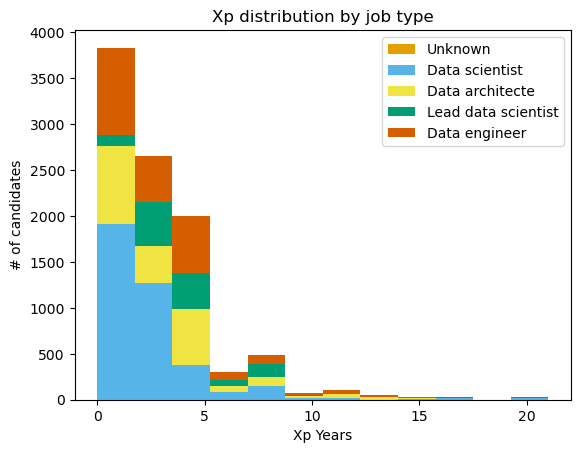

In [14]:
# Make a separate list for each airline
x1 = list(df_filled[df_filled['Metier'] == 'Data scientist']['Experience'])
x2 = list(df_filled[df_filled['Metier'] == 'Data architecte']['Experience'])
x3 = list(df_filled[df_filled['Metier'] == 'Lead data scientist']['Experience'])
x4 = list(df_filled[df_filled['Metier'] == 'Data engineer']['Experience'])
x5 = list(df_filled[df_filled['Metier'] == 'Unknown']['Experience'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['Unknown', 'Data scientist', 'Data architecte', 'Lead data scientist',
         'Data engineer']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x5, x1, x2, x3, x4], bins = int(180/15), stacked = True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Xp Years')
plt.ylabel('# of candidates')
plt.title('Xp distribution by job type')

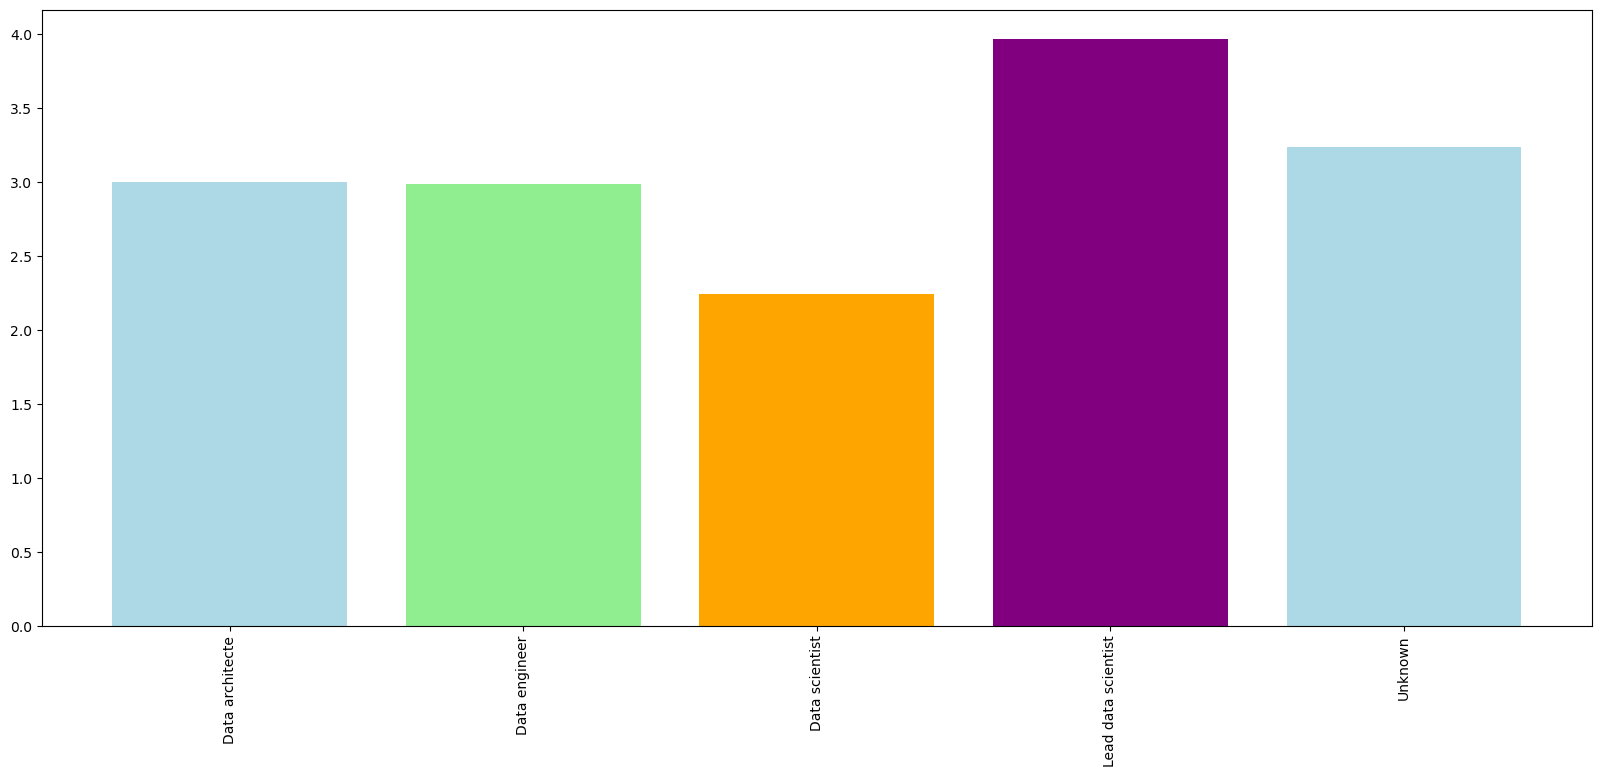

In [15]:
# Visualize the experience average by job
exp_avgs = df_filled.groupby('Metier')['Experience'].mean()
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(exp_avgs.index, exp_avgs.values, \
        color=['lightblue', 'lightgreen', 'orange', 'purple']) #y axis = avg experience, x axis = jobs
plt.show()

#### Focus: Technologies

In [16]:
# Let's split the items in each row to multiple columns then restack them in the same column
df_filled['Candidate'] = df_filled.index # to identify a single row per candidate
df_expand = df_filled['Technologies'].str.split('/', expand=True).stack().reset_index(level=1, drop=True).to_frame('Technologies')

# Join with initial database to get for each candidate a row for each technologie  
df_stacked = df_filled.drop('Technologies', axis=1).join(df_expand)

# The above step serves to identify if there a duplicated technologies for a single candidate:
print('Number of duplicates: ',df_stacked.duplicated(subset=df_stacked.columns).sum())

Number of duplicates:  0


In [17]:
#Get list of highest occurencies in Technologies and the share:
high_occ_tech = df_stacked.Technologies.value_counts().nlargest(5).index.values
print ('Most used Technologies: ',high_occ_tech)

df_reduced = df_stacked[df_stacked.Technologies.isin(high_occ_tech)]

for tech in high_occ_tech:
    df_reduced.loc[df_reduced.Technologies == tech, "Share%"] = len(df_reduced[df_reduced.Technologies == tech])/len(df_reduced)

Most used Technologies:  ['Python' 'R' 'SQL' 'Java' 'Hadoop']


C:\Users\marianne.chehade\AppData\Local\Temp\ipykernel_2672\2250980259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced.loc[df_reduced.Technologies == tech, "Share%"] = len(df_reduced[df_reduced.Technologies == tech])/len(df_reduced)


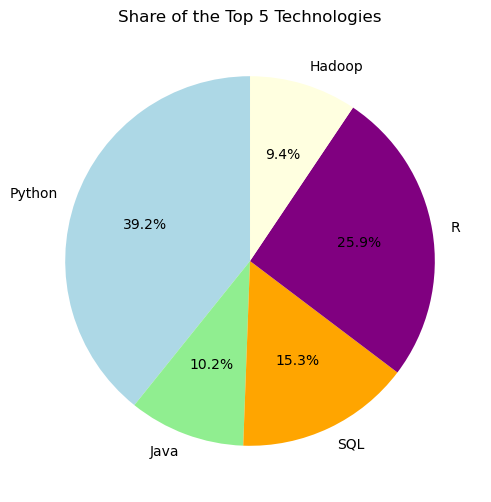

In [18]:
# Compute share of each one the top 5 technologies
share_array = []

for tech in df_reduced.Technologies.unique():
    share = df_reduced[df_reduced.Technologies == tech]['Share%'].unique()[0]
    share_array.append(share)
    
# Sample data
labels = df_reduced.Technologies.unique()
sizes = share_array

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, \
        colors=['lightblue', 'lightgreen', 'orange', 'purple', 'lightyellow'])
plt.title('Share of the Top 5 Technologies')
plt.show()

## Feature Engineering

In [19]:
# from openai import OpenAI


# client = OpenAI(
#     # This is the default and can be omitted
#     api_key=os.environ.get("OPENAI_API_KEY"),
# )

# chat_completion = client.chat.completions.create(
#     messages=[
#         {
#             "role": "user",
#             "content": "Say this is a test",
#         }
#     ],
#     model="gpt-3.5-turbo",
# )

#### Transformation to categorical variables:
##### Experience variable
Let's transform Experience into 4 groups: Debutant, Confirme, Senior & Expert
* Debutant: 0 years of experience -> 1 year
* Confirme: >1 year -> 2.5 years
* Senior: >2.5 years -> 4 years
* Expert : >4 years

We decided the intervals based on market standards

In [20]:
df_filled.loc[(df_filled['Experience'] >= 0) & (df_filled['Experience'] <= 1), 'XP_Category'] = 'Debutant'
df_filled.loc[(df_filled['Experience'] > 1) & (df_filled['Experience'] <= 2.5), 'XP_Category'] = 'Confirme'
df_filled.loc[(df_filled['Experience'] > 2.5) & (df_filled['Experience'] <= 4), 'XP_Category'] = 'Senior'
df_filled.loc[(df_filled['Experience'] > 4), 'XP_Category'] = 'Expert'

df_filled.XP_Category.value_counts()

XP_Category
Confirme    2907
Debutant    2811
Senior      2272
Expert      1592
Name: count, dtype: int64

##### Entreprise variable
Entrepise column has a lot of values - we need to transform it into a meaningful column \
We can get the sector of each company and use this information in the classification:
* Through an API
* Key words search in the name of each company: "Pharmacy" -> pharmaceutica. Risk: Not optimal as not all companies have key words ans they can be typed differently!
* Manually ! This is risky because it needs manual maintance - However, we decide to go with the solution for the test

In [21]:
# import requests

# api_key = 'Q9D3HXS4XNPW6THA'

# def get_sector(company_symbol):
#     base_url = 'https://www.alphavantage.co/query'
#     function = 'OVERVIEW'
    
#     params = {
#         'function': function,
#         'symbol': company_symbol,
#         'apikey': api_key,
#     }

#     response = requests.get(base_url, params=params)
#     data = response.json()

#     if 'Sector' in data:
#         return data['Sector']
#     else:
#         return print('Not found')

# # List of companies
# companies = [
#     'Advanced Technology Solutions, Inc',
#     'American Environmental Assessment',
#     'Xylem',
#     'DV Trading LLC',
#     'Aristotle',
#     'Park Assist LLC',
#     "Children's Hospital Los Angeles",
#     'Department of Energy',
#     'Cedars-Sinai Medical Center',
#     'KPMG',
#     'Apple'
# ]

# # Get sector for each company
# sectors = {}
# for company in companies:
#     sector = get_sector(company)
#     sectors[company] = sector

# # Print the sectors
# for company, sector in sectors.items():
#     print(f"{company}: {sector}")


#### Create new variable based on top 5 technologies used:

In [22]:
tech_list = ['Python', 'R', 'SQL', 'Java', 'Hadoop']

# Compute the number of technologies used from the top 5, if none = 0
for tech in tech_list:
    df_filled['Tech_rank']  = df_filled['Technologies'].apply(lambda x: sum(tech in x for tech in tech_list))

df_filled.Tech_rank.value_counts()

Tech_rank
1    3712
2    3300
3    1941
4     423
0     206
Name: count, dtype: int64

### ML Supervisé

We will used a Random Forest Classifier to predict the missing values\
Steps:
* Use LabelEncoder on variables with ordinal relationship
* Split the dataset between missing and none-missing values
* Use second dataframe to build the model

In [50]:
# Transforming Metier into numeral categories

df_encoded = df_filled.copy()

df_encoded.loc[df_encoded.Metier=='Data scientist', 'Metier_Cat'] = 1
df_encoded.loc[df_encoded.Metier=='Data architecte', 'Metier_Cat'] = 2
df_encoded.loc[df_encoded.Metier=='Lead data scientist', 'Metier_Cat'] = 3
df_encoded.loc[df_encoded.Metier=='Data engineer', 'Metier_Cat'] = 4
df_encoded.loc[df_encoded.Metier=='Unknown', 'Metier_Cat'] = 5

df_encoded.Metier_Cat.value_counts()

Metier_Cat
1.0    3865
4.0    2347
2.0    2123
3.0    1228
5.0      19
Name: count, dtype: int64

In [51]:
# Encoding ordinal columns that will be used in classifier

# Set order from least to most:
order_dip = ['No diploma', 'Bachelor', 'Master', 'Phd']
order_tech = [0, 1, 2, 3, 4]
order_xp = ['Debutant', 'Confirme', 'Senior', 'Expert']

# Encode columns:
df_encoded['Diplome_OE'] = OrdinalEncoder(categories=[order_dip]).fit_transform(df_encoded[['Diplome']])
df_encoded['Tech_OE'] = OrdinalEncoder(categories=[order_tech]).fit_transform(df_encoded[['Tech_rank']])
df_encoded['XP_OE'] = OrdinalEncoder(categories=[order_xp]).fit_transform(df_encoded[['XP_Category']])

print(df_encoded.Diplome_OE.value_counts())
print(df_encoded.Tech_OE.value_counts())
print(df_encoded.XP_OE.value_counts())

Diplome_OE
2.0    4971
3.0    2258
1.0    1392
0.0     961
Name: count, dtype: int64
Tech_OE
1.0    3712
2.0    3300
3.0    1941
4.0     423
0.0     206
Name: count, dtype: int64
XP_OE
1.0    2907
0.0    2811
2.0    2272
3.0    1592
Name: count, dtype: int64


In [ ]:
# Label Encoder on technologies

df_encoded['Tech_LE'] = LabelEncoder().fit_transform(df_encoded[['Technologies']])

In [55]:
# Let's continue by splitting the database between known and unkonwn job (4)

#keep only needed columns:
df_encoded_initial = df_encoded.copy()
df_encoded = df_encoded[['Candidate' ,'Metier_Cat', "XP_OE", "Diplome_OE", "Tech_LE"]]

df_metier = df_encoded[df_encoded['Metier_Cat'] != 5]
print("Rows with Metier not null:", df_metier.shape[0])

df_no_metier = df_encoded[df_encoded['Metier_Cat'] == 5]
print("Rows with Metier Unkown", df_no_metier.shape[0])

Rows with Metier not null: 9563
Rows with Metier Unkown 19


ACCURACY: TRAIN=0.8918 TEST=0.8600
LOG LOSS: 0.4989377135126764
Classification Report:
               precision    recall  f1-score   support

         1.0       0.80      0.92      0.86       400
         2.0       0.95      0.95      0.95       199
         3.0       0.60      0.33      0.42       125
         4.0       0.97      0.96      0.97       233

    accuracy                           0.86       957
   macro avg       0.83      0.79      0.80       957
weighted avg       0.85      0.86      0.85       957



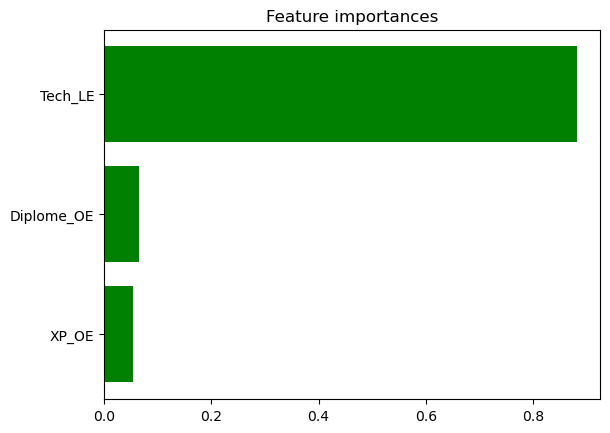

In [56]:
X = df_metier[["XP_OE", "Diplome_OE", "Tech_LE"]].values #only keep values to use in classification
Y = df_metier["Metier_Cat"].values #Value to predict

# We split the dataframe into Train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# Instanciate the classifier
forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)
# Fit the model
forest.fit(X_train, Y_train)

# use the model to predict the value in the test set
y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

# Evaluate the model
accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

classification_report_output = classification_report(Y_test, y_pred)
print("Classification Report:\n", classification_report_output)

#Features Importance
importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_metier.drop('Candidate', axis=1).iloc[:, 1:].columns[indices])

plt.gca().invert_yaxis()


We can see the Technologies used are the one that contribute the most to the prediction.\
In fact, technologies used differ between Data scientists, engineers and architects - hence it justifies the importance of the feature

In [233]:
result = permutation_importance(forest, X_test, Y_test, n_repeats=10, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = df_metier.drop(['Candidate', 'Metier_Cat'], axis=1).columns

pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=True)

,Importance,Std
XP_OE,0.018600,0.006638
Diplome_OE,0.028004,0.004692
Tech_LE,0.519331,0.011389


We run a permuation importance - it allows to measure the change in the model's performance when we shuffle the features values.\
As we can see, this second test confirm that that Technologies is the most important feature

In [64]:
# predict real values

df_no_metier_initial = df_no_metier.copy()
df_no_metier = df_no_metier.drop(['Metier_Cat','Candidate'], axis=1)
prediction = forest.predict(df_no_metier)
df_no_metier.insert(0, 'Metier_Cat', prediction)
df_no_metier.insert(0, 'Candidate', df_no_metier_initial['Candidate'])

# Join with initial dataframe
df_predicted = pd.concat([df_metier, df_no_metier], axis=0)
df_predicted

C:\Users\marianne.chehade\Anaconda3\envs\equancy\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


### Unsupervised Classification

We're going to run two methods:
* Hierarchical
* Non-hierarchical using K-means

#### Hierarchical Clustering

In [217]:
# adding Tech_OE -> categories within top 5 tech : it will be easier for classification purposes
df_merged = pd.merge(df_predicted, df_encoded_initial[['Candidate', 'Tech_OE']])
df_merged

,Candidate,Metier_Cat,XP_OE,Diplome_OE,Tech_LE,Tech_OE
0,0,1.0,0.0,2.0,27,1.0
1,1,2.0,2.0,2.0,34,2.0
2,2,3.0,2.0,2.0,51,3.0
3,3,1.0,1.0,2.0,2,2.0
4,4,1.0,1.0,3.0,26,1.0
...,...,...,...,...,...,...
9577,7228,4.0,1.0,2.0,23,2.0
9578,7330,1.0,0.0,3.0,9,2.0
9579,9087,2.0,2.0,0.0,14,1.0
9580,9427,1.0,0.0,2.0,39,2.0


In [218]:
# Let's scale the data

data_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(df_merged.drop(['Candidate', 'Tech_OE'], axis=1))
scaled_data.shape

(9582, 4)

In [205]:
complete_clustering = linkage(scaled_data, method="complete", metric="euclidean")
average_clustering = linkage(scaled_data, method="average", metric="euclidean")

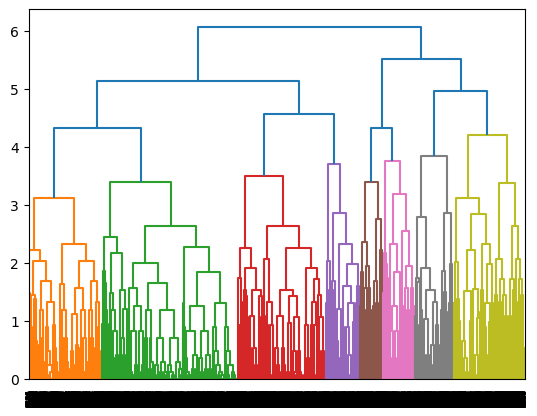

In [206]:
dendrogram(complete_clustering)
plt.show()

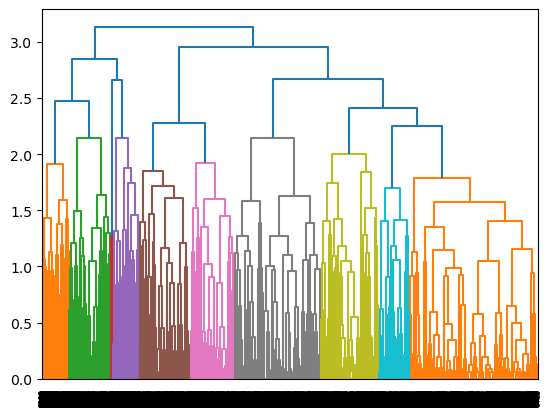

In [207]:
dendrogram(average_clustering)
plt.show()

In [235]:
# Both methods suggest having 2 clusters - We're going with the complete linkage as it is less sensitive to outliers: 

cluster_labels = cut_tree(complete_clustering, n_clusters=2).reshape(-1, )
df_merged["Cluster_Hier"] = cluster_labels

<Axes: xlabel='Cluster_Hier', ylabel='Metier_Cat'>

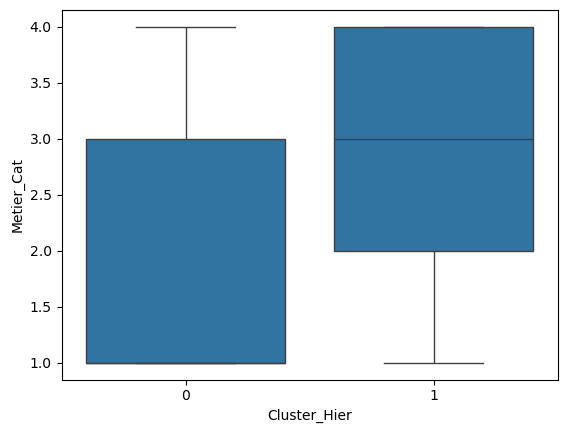

In [219]:
# Visualize boxplot for each of the features

sns.boxplot(x='Cluster_Hier', y='Metier_Cat', data=df_merged.drop(['Candidate' ,'Tech_LE'], axis=1))

<Axes: xlabel='Cluster_Hier', ylabel='XP_OE'>

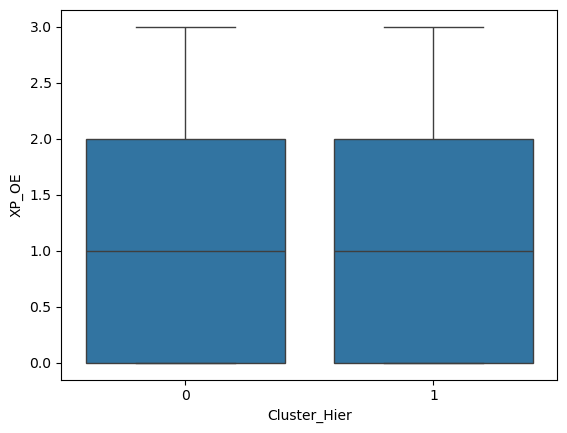

In [220]:
sns.boxplot(x='Cluster_Hier', y='XP_OE', data=df_merged.drop(['Candidate' ,'Tech_LE'], axis=1))

<Axes: xlabel='Cluster_Hier', ylabel='Diplome_OE'>

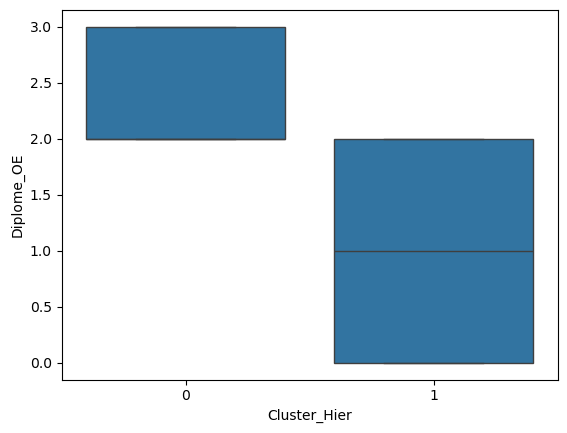

In [221]:
sns.boxplot(x='Cluster_Hier', y='Diplome_OE', data=df_merged.drop(['Candidate' ,'Tech_LE'], axis=1))

<Axes: xlabel='Cluster_Hier', ylabel='Tech_OE'>

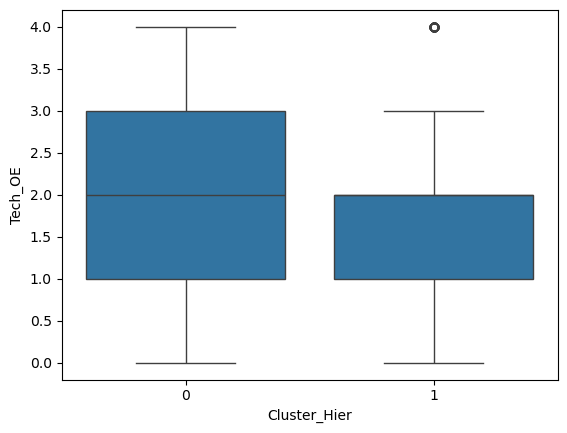

In [222]:
sns.boxplot(x='Cluster_Hier', y='Tech_OE', data=df_merged.drop(['Candidate' ,'Tech_LE'], axis=1))

In [261]:
# Calculate Silhouette Score: closer to 1 the more the clustered are defined
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
silhouette_avg

0.20321186910212136

Result shows that the clusters are not very well defined

#### Non-hierarchical clustering: k-means

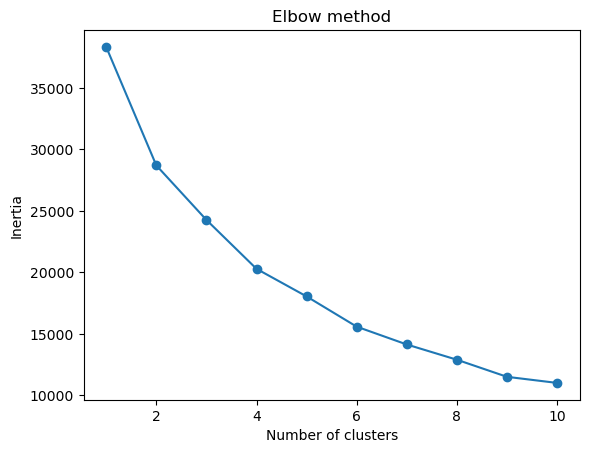

In [262]:
# Start by choosing the number of clusters using the Elbow method

inertias = []

X = scaled_data #to fit

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    
    inertias.append(kmeans.inertia_)

# Plot Inertias
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()

It show that 2 is the ideal number - so we will set k=2

In [263]:
# Compute Silhoutte Score

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
silhouette_score(X, kmeans.labels_)

0.23554276170178515

Results with K-means give a slightly higher result - but still the performance isn't very high

In [225]:
# Add clusters to the final table
kmeans = KMeans(n_clusters = 2)
kmeans.fit(df_merged.drop(['Candidate', 'Tech_LE', 'Cluster_Hier'], axis=1))

df_merged["Cluster_kmeans"] = kmeans.labels_
df_merged

,Candidate,Metier_Cat,XP_OE,Diplome_OE,Tech_LE,Tech_OE,Cluster_Hier,Cluster_kmeans
0,0,1.0,0.0,2.0,27,1.0,0,1
1,1,2.0,2.0,2.0,34,2.0,0,1
2,2,3.0,2.0,2.0,51,3.0,0,0
3,3,1.0,1.0,2.0,2,2.0,0,1
4,4,1.0,1.0,3.0,26,1.0,0,1
...,...,...,...,...,...,...,...,...
9577,7228,4.0,1.0,2.0,23,2.0,1,0
9578,7330,1.0,0.0,3.0,9,2.0,0,1
9579,9087,2.0,2.0,0.0,14,1.0,1,0
9580,9427,1.0,0.0,2.0,39,2.0,0,1


C:\Users\marianne.chehade\AppData\Local\Temp\ipykernel_2672\2022341766.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(df_merged['Cluster_kmeans'], df_merged['Tech_OE'], s=50, cmap='viridis')
C:\Users\marianne.chehade\AppData\Local\Temp\ipykernel_2672\2022341766.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1].scatter(df_merged['Cluster_kmeans'], df_merged['XP_OE'], s=50, cmap='viridis')
C:\Users\marianne.chehade\AppData\Local\Temp\ipykernel_2672\2022341766.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[2].scatter(df_merged['Cluster_kmeans'], df_merged['Diplome_OE'], s=50, cmap='viridis')
C:\Users\marianne.chehade\AppData\Local\Temp\ipykernel_2672\2022341766.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[3].scatter(df_merged['Cluster_kmeans'], df_merged['Me

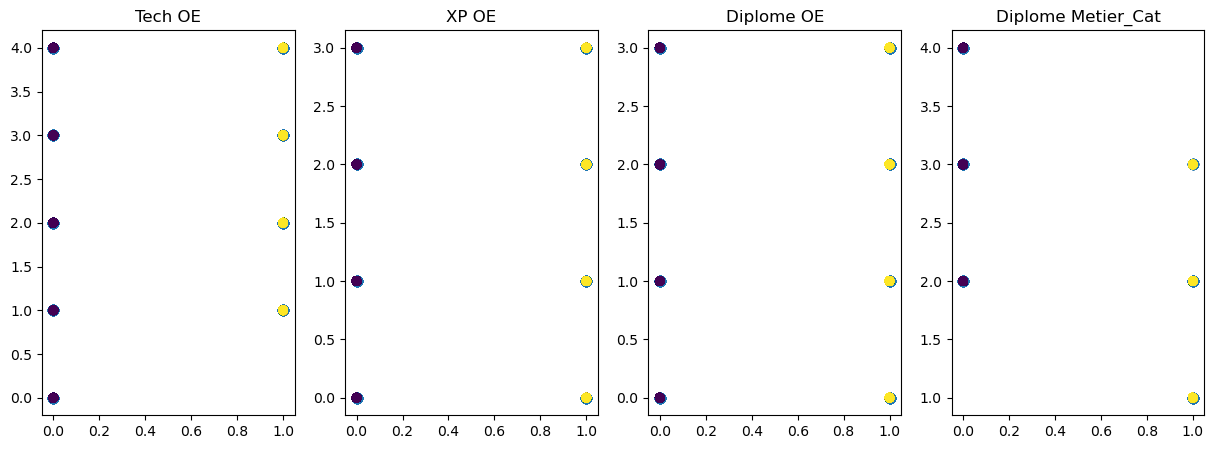

In [226]:
# Scatter plot
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].scatter(df_merged['Cluster_kmeans'], df_merged['Tech_OE'], s=50, cmap='viridis')
axs[0].scatter(df_merged['Cluster_kmeans'], df_merged['Tech_OE'], c = kmeans.labels_)
axs[0].set_title('Tech OE')

axs[1].scatter(df_merged['Cluster_kmeans'], df_merged['XP_OE'], s=50, cmap='viridis')
axs[1].scatter(df_merged['Cluster_kmeans'], df_merged['XP_OE'], c = kmeans.labels_)
axs[1].set_title('XP OE')

axs[2].scatter(df_merged['Cluster_kmeans'], df_merged['Diplome_OE'], s=50, cmap='viridis')
axs[2].scatter(df_merged['Cluster_kmeans'], df_merged['Diplome_OE'], c = kmeans.labels_)
axs[2].set_title('Diplome OE')

axs[3].scatter(df_merged['Cluster_kmeans'], df_merged['Metier_Cat'], s=50, cmap='viridis')
axs[3].scatter(df_merged['Cluster_kmeans'], df_merged['Metier_Cat'], c = kmeans.labels_)
axs[3].set_title('Diplome Metier_Cat')

plt.show()

### Interpretation, Limits & Next Steps